In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
# Obtain these by inspecting the files
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [3]:
def load_data():
  # Returns:
  # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
  # Xtest (Ntest x T x D), Ytest (Ntest)

  Xtrain = np.zeros((Ntrain, T, D))
  Xtest = np.zeros((Ntest, T, D))

  # train data
  ts_filenames = [
    'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt',
    'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
    'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt',
  ]

  ts_file_prefix = 'Datasets/UCI HAR Dataset/train/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtrain[:, :, d] = x
  
  # train labels
  Ytrain = pd.read_csv(
      f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1

  # test data
  ts_filenames = [
    'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_x_test.txt',
    'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
    'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt',
  ]

  ts_file_prefix = 'Datasets/UCI HAR Dataset/test/'

  for d, fn in enumerate(ts_filenames):
    df = pd.read_csv(
        f'{ts_file_prefix}Inertial Signals/{fn}',
        header=None,
        delim_whitespace=True)

    # Ntrain x T array
    x = df.to_numpy()
    Xtest[:, :, d] = x
  
  # test labels
  Ytest = pd.read_csv(
      f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1

  return Xtrain, Ytrain, Xtest, Ytest

In [ ]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

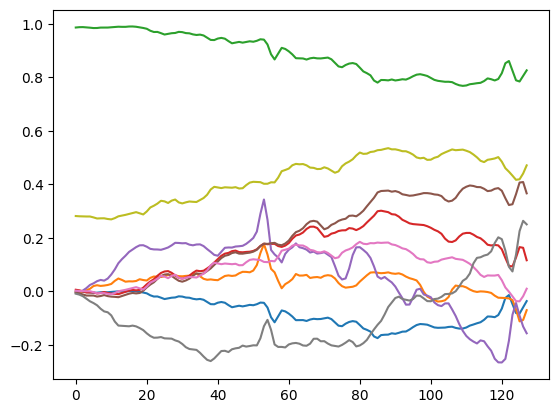

In [5]:
# plot all D=9 time series of length T=128
plt.plot(Xtrain[7000, :, :]);

In [6]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
# x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [7]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [8]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [9]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=10,
  callbacks=[check_point],
  validation_data=(Xtest, Ytest),
)

Epoch 1/10
230/230 [==============================] - 8s 20ms/step - loss: 1.0526 - accuracy: 0.7035 - val_loss: 0.6302 - val_accuracy: 0.8273
Epoch 2/10
230/230 [==============================] - 4s 15ms/step - loss: 0.4629 - accuracy: 0.8822 - val_loss: 0.4218 - val_accuracy: 0.8734
Epoch 3/10
230/230 [==============================] - 4s 16ms/step - loss: 0.2722 - accuracy: 0.9217 - val_loss: 0.3346 - val_accuracy: 0.8924
Epoch 4/10
230/230 [==============================] - 4s 17ms/step - loss: 0.2092 - accuracy: 0.9365 - val_loss: 0.2949 - val_accuracy: 0.8938
Epoch 5/10
230/230 [==============================] - 4s 17ms/step - loss: 0.1726 - accuracy: 0.9434 - val_loss: 0.2735 - val_accuracy: 0.9009
Epoch 6/10
230/230 [==============================] - 4s 17ms/step - loss: 0.1562 - accuracy: 0.9436 - val_loss: 0.3012 - val_accuracy: 0.8816
Epoch 7/10
230/230 [==============================] - 4s 17ms/step - loss: 0.1530 - accuracy: 0.9464 - val_loss: 0.2999 - val_accuracy: 0.8826

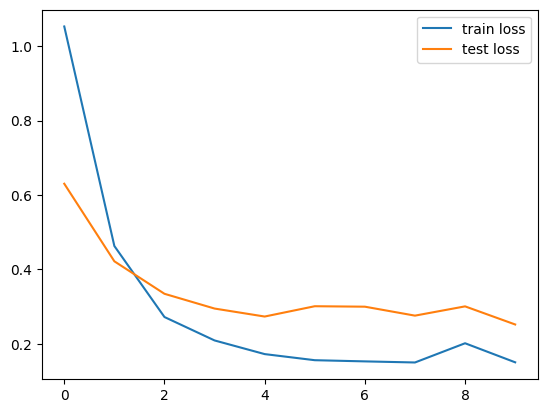

In [10]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

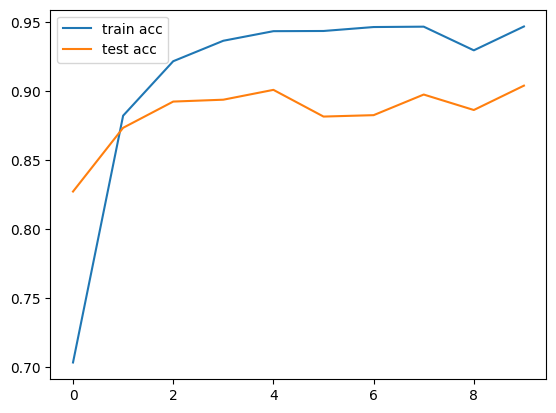

In [11]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [12]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [13]:
# make predictions
Ptest = best_model.predict(Xtest)

93/93 [==============================] - 1s 9ms/step


In [14]:
from sklearn.preprocessing import StandardScaler

def load_features():
  # Returns:
  # X_train (Ntrain x D)
  # X_test (Ntest x D)

  # train data
  df = pd.read_csv(
        'Datasets/UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True)
  
  feat_train = df.to_numpy()

  # test data
  df = pd.read_csv(
        'Datasets/UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True)
  
  feat_test = df.to_numpy()

  scaler = StandardScaler()
  feat_train = scaler.fit_transform(feat_train)
  feat_test = scaler.transform(feat_test)

  return feat_train, feat_test

In [ ]:
feat_train, feat_test = load_features()

In [16]:
D_feat = feat_train.shape[1]

In [17]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(32, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

In [ ]:
tf.keras.utils.plot_model(model)

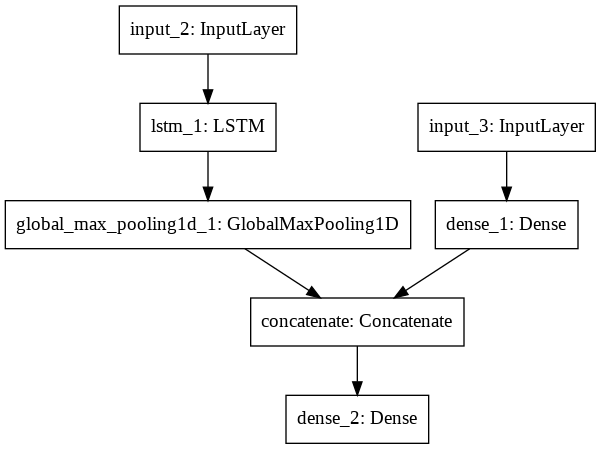

In [18]:
check_point = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [19]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy'],
)

In [20]:
r = model.fit(
  [Xtrain, feat_train],
  Ytrain,
  epochs=15,
  callbacks=[check_point],
  validation_data=([Xtest, feat_test], Ytest),
)

Epoch 1/15
230/230 [==============================] - 5s 18ms/step - loss: 0.3219 - accuracy: 0.8863 - val_loss: 0.2063 - val_accuracy: 0.9230
Epoch 2/15
230/230 [==============================] - 4s 16ms/step - loss: 0.1047 - accuracy: 0.9655 - val_loss: 0.2185 - val_accuracy: 0.9145
Epoch 3/15
230/230 [==============================] - 4s 18ms/step - loss: 0.0729 - accuracy: 0.9729 - val_loss: 0.1737 - val_accuracy: 0.9338
Epoch 4/15
230/230 [==============================] - 4s 16ms/step - loss: 0.0589 - accuracy: 0.9799 - val_loss: 0.1661 - val_accuracy: 0.9359
Epoch 5/15
230/230 [==============================] - 4s 18ms/step - loss: 0.0534 - accuracy: 0.9805 - val_loss: 0.1780 - val_accuracy: 0.9372
Epoch 6/15
230/230 [==============================] - 4s 18ms/step - loss: 0.0471 - accuracy: 0.9842 - val_loss: 0.1894 - val_accuracy: 0.9399
Epoch 7/15
230/230 [==============================] - 4s 18ms/step - loss: 0.0434 - accuracy: 0.9837 - val_loss: 0.2259 - val_accuracy: 0.9264

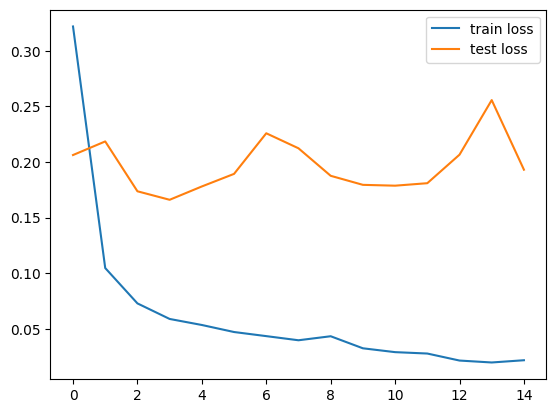

In [21]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

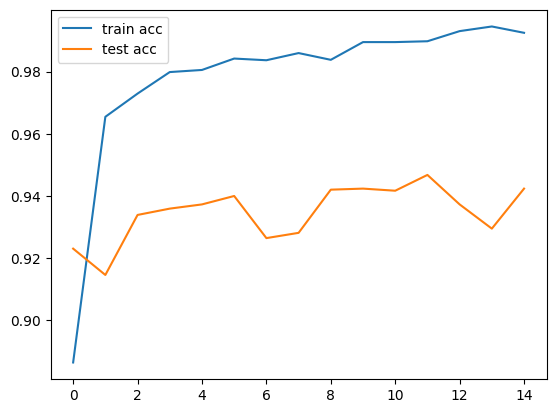

In [22]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [23]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [24]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

93/93 [==============================] - 1s 7ms/step


In [25]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

0.9467254835425857